In [1]:
library(tidyverse)
library(repr)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
options(repr.plot.width=4, repr.plot.height=3)

In [3]:
ads_df = as_tibble(read.csv('data/ads.csv'))
dbr_df = as_tibble(read.csv('data/delivery_by_region.csv'))

In [28]:
ads_df$page_name_short = substr(ads_df$page_name, 1, 20)

# How much money was spent in each fb group?

In [38]:
ads_df$spend_estimate = (ads_df$spend_lower_bound + ads_df$spend_upper_bound)/2
ads_df$impressions_estimate = (ads_df$impressions_lower_bound + ads_df$impressions_upper_bound)/2

In [29]:
spend_by_page_df = ads_df %>% group_by(page_name_short) %>% summarise(spend_estimate = sum(spend_estimate))

In [41]:
options(repr.plot.width=6, repr.plot.height=4)

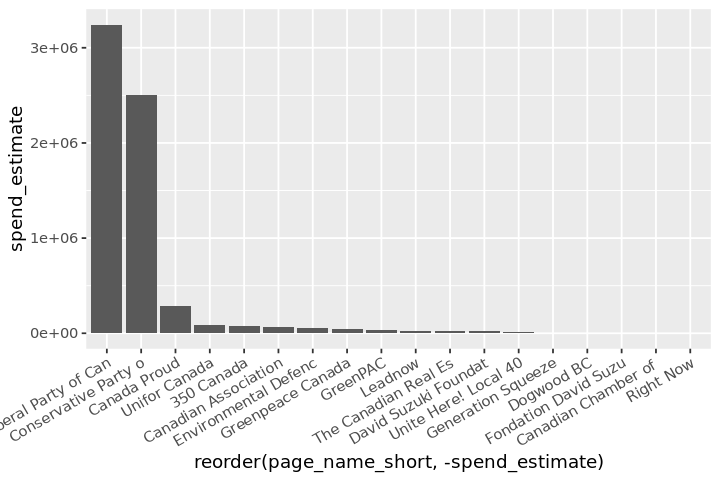

In [46]:
ggplot(data = spend_by_page_df) + 
    geom_col(mapping = aes(x = reorder(page_name_short, -spend_estimate), y = spend_estimate)) +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1))

## Relationship between spent value and audience reached (impressions)

Warning message:
“Removed 53 rows containing missing values (geom_point).”

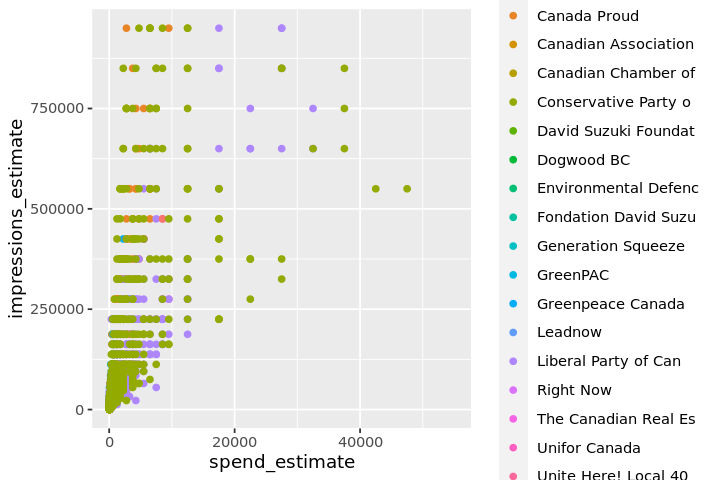

In [49]:
# There is a clear positive and linear relationship between amount spent and number of impressions
ggplot(data = ads_df) +
    geom_point(mapping = aes(x = spend_estimate, y = impressions_estimate, color = page_name_short))

# Relationship between time of ad running and impressions

In [53]:
ads_df$running_time = ads_df$ad_delivery_stop_time = ads_df$ad_delivery_stop_time